# Filmek portfólióelemzése

<h2>Tartalomjegyzék</h2>

<ul style="font-size: 16px; line-height: 1.8;">
  <li><a href="#1-bevezetes-es-celkituzes"><b>1) Bevezetés és célkitűzés</b></a></li>
  <li><a href="#2-adatok-megertese-es-elokeszitese"><b>2) Adatok megértése és előkészítése</b></a></li>
  <li><a href="#3-leiro-statisztikak"><b>3) Leíró statisztikák</b></a></li>
  <li><a href="#4-egyvaltozos-eloszlasok"><b>4) Egyváltozós eloszlások</b></a></li>
  <li><a href="#bivariate-analysis"><b>5) Kétváltozós kapcsolatok (bivariáns elemzés)</b></a></li>
  <li><a href="#6-kozonsegkozpontu-vizualizaciok"><b>6) Közönségközpontú vizualizációk</b></a></li>
  <li><a href="#7-kovetkeztetesek"><b>7) Következtetések</b></a></li>
</ul>

<a id="1-bevezetes-es-celkituzes"></a>
## 1) Bevezetés és célkitűzés

A projekt célja annak feltárása, hogy milyen kapcsolatok állnak fenn a közönségfogadtatás, a kritikusok értékelései, a jegybevétel és a jövedelmezőség között a 2007 és 2011 között bemutatott, népszerű filmek körében.

Az elemzés konkrét céljai:
- A közönségpontszámok és a kritikuspontszámok közötti kapcsolat vizsgálata.
- Annak értékelése, hogy a magasabb közönség- vagy kritikusértékelések együtt járnak-e magasabb világméretű bevétellel.
- A bevétel és a jövedelmezőség kapcsolatának elemzése annak figyelembevételével, hogy az erős box office teljesítmény nem feltétlenül jelent magas jövedelmezőséget.
- Műfajszintű mintázatok azonosítása aggregált mutatók (pl. medián értékek) segítségével, a közönségpreferenciák és a kritikai fogadtatás közötti különbségek jobb megértése érdekében.
- Megfelelő transzformációk (pl. logaritmikusan transzformált bevétel) alkalmazása a ferde eloszlások kezelésére és az értelmezhetőség javítására.

A projekt az exploratív adatelemzésre és a vizuális értelmezésre helyezi a hangsúlyt, nem pedig prediktív modellezésre, azzal a céllal, hogy világos, adatvezérelt következtetéseket vonjon le valós filmipari teljesítményadatok alapján.

<a id="2-adatok-megertese-es-elokeszitese"></a>
## 2) Adatok megértése és előkészítése

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

#diagram általános beállítások
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.titleweight"] = "semibold"
plt.rcParams["axes.titlecolor"] = "#222222"
plt.rcParams["axes.titlepad"] = 12
plt.rcParams["axes.titlelocation"] = "center"
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.style"] = "italic"

plt.rcParams["axes.facecolor"] = "#F3E6D3"

plt.rcParams.update({
    "axes.facecolor": "#F3E6D3",
    "axes.grid": True,
    "grid.alpha": 0.12,
    "axes.axisbelow": True,
    "xtick.minor.visible": True,
    "ytick.minor.visible": True
})

In [131]:
df = pd.read_csv('movies.csv')
print(df.shape)
print(df.info())
df.head()

(77, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Film               77 non-null     object 
 1   Genre              77 non-null     object 
 2   Lead Studio        77 non-null     object 
 3   Audience score %   77 non-null     int64  
 4   Profitability      77 non-null     float64
 5   Rotten Tomatoes %  77 non-null     int64  
 6   Worldwide Gross    77 non-null     object 
 7   Year               77 non-null     int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 4.9+ KB
None


,Film,Genre,Lead Studio,Audience score %,Profitability,Rotten Tomatoes %,Worldwide Gross,Year
0,Zack and Miri Make a Porno,Romance,The Weinstein Company,70,1.747542,64,$41.94,2008
1,Youth in Revolt,Comedy,The Weinstein Company,52,1.090000,68,$19.62,2010
2,You Will Meet a Tall Dark Stranger,Comedy,Independent,35,1.211818,43,$26.66,2010
3,When in Rome,Comedy,Disney,44,0.000000,15,$43.04,2010
4,What Happens in Vegas,Comedy,Fox,72,6.267647,28,$219.37,2008


In [132]:
df.duplicated().sum()

np.int64(2)

In [133]:
df["Genre"].value_counts()

Genre
Comedy       41
Romance      13
Drama        13
Animation     4
Fantasy       1
Romence       1
Comdy         1
Action        1
romance       1
comedy        1
Name: count, dtype: int64

In [134]:
df["Worldwide Gross"].head(10)

0     $41.94 
1     $19.62 
2     $26.66 
3     $43.04 
4    $219.37 
5    $117.09 
6    $521.28 
7     $22.18 
8      $0.03 
9    $217.57 
Name: Worldwide Gross, dtype: object

**Kezdeti megfigyelések:**
- Az adathalmaz filmenként tartalmaz értékelési, jövedelmezőségi és bevételi adatokat.
- Egyes oszlopok tisztítást igényelnek (műfajnevek egységesítése, duplikátumok kezelése, pénznem-formátum).
- A jövedelmezőségi változóban szereplő nulla értékek feltehetően hiányzó adatokat jelölnek.

### Adattisztítás és adatelőkészítés

Ebben a szakaszban az adathalmaz tisztítását végzem el: eltávolítom a teljesen azonos duplikátumokat, egységesítem a műfajneveket, a pénznem formátumú értékeket numerikussá alakítom, valamint kezelem a nulla jövedelmezőségi értékeket.

In [135]:
df_raw = df.copy()

print("Sorok száma (előtte):", df.shape[0])
print("Teljesen azonos duplikátumok (előtte):", df.duplicated().sum())
print("Egyedi műfajok száma (előtte):", df["Genre"].nunique())
print("Worldwide Gross adattípus (előtte):", df["Worldwide Gross"].dtype)

Sorok száma (előtte): 77
Teljesen azonos duplikátumok (előtte): 2
Egyedi műfajok száma (előtte): 10
Worldwide Gross adattípus (előtte): object


In [136]:
df = df.drop_duplicates()

print("Sorok száma (drop_duplicates után):", df.shape[0])
print("Teljesen azonos duplikátumok (utána):", df.duplicated().sum())

Sorok száma (drop_duplicates után): 75
Teljesen azonos duplikátumok (utána): 0


In [137]:
# A 'Genre' oszlop elején és végén lévő szóközök eltávolítása
df["Genre"] = df["Genre"].str.strip()

# Hibás vagy inkonzisztens műfajnevek cseréje egységes, helyes elnevezésekre
df["Genre"] = df["Genre"].replace({
    "Romence": "Romance",   # elírás javítása
    "Comdy": "Comedy",      # elírás javítása
    "romance": "Romance",   # kis- és nagybetűk egységesítése
    "comedy": "Comedy"      # kis- és nagybetűk egységesítése
})

# Annak megszámolása, hogy a tisztítás után hányszor fordul elő egyes műfaj
print(df["Genre"].value_counts())


Genre
Comedy       42
Romance      15
Drama        13
Animation     3
Fantasy       1
Action        1
Name: count, dtype: int64


In [138]:
# A 'Worldwide Gross' oszlop szöveggé alakítása
# Ez biztosítja, hogy a string műveletek biztonságosan alkalmazhatók legyenek
df["Worldwide Gross"] = (
    df["Worldwide Gross"]
    .astype(str)
    .str.replace("$", "", regex=False)  # dollárjel eltávolítása
    .str.strip()                        # elején és végén lévő szóközök eltávolítása
)

# A megtisztított oszlop numerikussá (float) alakítása
# Az érvénytelen értékek NaN-ná alakulnak hiba dobása helyett
df["Worldwide Gross"] = pd.to_numeric(
    df["Worldwide Gross"],
    errors="coerce"
)

# Az adattípus ellenőrzése az átalakítás után
print("Worldwide Gross adattípus (utána):", df["Worldwide Gross"].dtype)

# Az átalakítás során keletkezett hiányzó értékek száma
print("Worldwide Gross hiányzó értékek (utána):", df["Worldwide Gross"].isna().sum())

# Az első 10 érték megtekintése
df["Worldwide Gross"].head(10)

Worldwide Gross adattípus (utána): float64
Worldwide Gross hiányzó értékek (utána): 0


0     41.94
1     19.62
2     26.66
3     43.04
4    219.37
5    117.09
6    521.28
7     22.18
8      0.03
9    217.57
Name: Worldwide Gross, dtype: float64

In [139]:
# A 0 jövedelmezőségi értékek hiányzó/ismeretlen adatként való értelmezése valódi nulla helyett
df["Profitability"] = df["Profitability"].replace(0, np.nan)

print("Hiányzó jövedelmezőségi értékek (utána):", df["Profitability"].isna().sum())
df[["Film", "Profitability"]].head(10)

Hiányzó jövedelmezőségi értékek (utána): 3


,Film,Profitability
0,Zack and Miri Make a Porno,1.747542
1,Youth in Revolt,1.090000
2,You Will Meet a Tall Dark Stranger,1.211818
3,When in Rome,NaN
4,What Happens in Vegas,6.267647
5,Water For Elephants,3.081421
6,WALL-E,2.896019
7,Waitress,11.089742
8,Waiting For Forever,0.005000
9,Valentine's Day,4.184038


In [140]:
df.info()
df.isna().sum()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 75 entries, 0 to 76
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Film               75 non-null     object 
 1   Genre              75 non-null     object 
 2   Lead Studio        75 non-null     object 
 3   Audience score %   75 non-null     int64  
 4   Profitability      72 non-null     float64
 5   Rotten Tomatoes %  75 non-null     int64  
 6   Worldwide Gross    75 non-null     float64
 7   Year               75 non-null     int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 5.3+ KB


,Audience score %,Profitability,Rotten Tomatoes %,Worldwide Gross,Year
count,75.000000,72.000000,75.000000,75.000000,75.000000
mean,63.720000,4.715803,46.493333,138.377467,2009.066667
std,13.699043,8.236327,26.412207,156.985150,1.349007
min,35.000000,0.005000,3.000000,0.030000,2007.000000
25%,52.000000,1.794048,26.000000,32.495000,2008.000000
50%,64.000000,2.645711,43.000000,77.090000,2009.000000
75%,75.000000,4.724879,64.500000,199.635000,2010.000000
max,89.000000,66.934000,96.000000,709.820000,2011.000000


**Tisztítás után:**
- Az adathalmaz 75 filmet tartalmaz.
- Két teljesen azonos duplikált sor eltávolításra került.
- A Worldwide Gross változó sikeresen numerikus (float) adattípussá lett alakítva.

<a id="3-leiro-statisztikak"></a>
## 3) Leíró statisztikák

Ebben a szakaszban összefoglalom a fő numerikus változókat, hogy a vizuális feltárás előtt áttekintsem azok központi tendenciáját, szóródását és nagyságrendjét.

In [141]:
numeric_cols = [
    "Audience score %",
    "Rotten Tomatoes %",
    "Worldwide Gross",
    "Profitability"
]

df[numeric_cols].describe()

,Audience score %,Rotten Tomatoes %,Worldwide Gross,Profitability
count,75.000000,75.000000,75.000000,72.000000
mean,63.720000,46.493333,138.377467,4.715803
std,13.699043,26.412207,156.985150,8.236327
min,35.000000,3.000000,0.030000,0.005000
25%,52.000000,26.000000,32.495000,1.794048
50%,64.000000,43.000000,77.090000,2.645711
75%,75.000000,64.500000,199.635000,4.724879
max,89.000000,96.000000,709.820000,66.934000


In [142]:
df[numeric_cols].median()

Audience score %     64.000000
Rotten Tomatoes %    43.000000
Worldwide Gross      77.090000
Profitability         2.645711
dtype: float64

**Fő megfigyelések:**

- A közönségpontszámok általában magasabbak, mint a kritikusok értékelései. A közönségpontszám mediánja 64%, míg a Rotten Tomatoes pontszám mediánja 43%.

- A közönség értékelései viszonylag kiegyensúlyozottak (szórás ≈ 13,7), míg a kritikusok pontszámai jóval nagyobb szóródást mutatnak (szórás ≈ 26,4).

- A Worldwide Gross eloszlása erősen jobbra ferde. Bár a medián bevétel 77 millió, a maximum meghaladja a 700 milliót, ami néhány rendkívül magas bevételű film jelenlétére utal.

- A jövedelmezőség jelentős mértékben eltér a filmek között. A medián jövedelmezőség körülbelül 2,65, ugyanakkor a maximum közel 67, ami extrém kiugró értékek jelenlétét jelzi.

<a id="4-egyvaltozos-eloszlasok"></a>
## 4) Egyváltozós eloszlások

Ebben a szakaszban a fő numerikus változók eloszlását vizualizálom annak érdekében, hogy megértsem azok alakját (ferdeségét), szóródását és az esetleges kiugró értékeket.

### A közönségpontszámok eloszlása

**Kérdés:** Hogyan oszlanak meg a közönségpontszámok az adathalmazban szereplő filmek között?

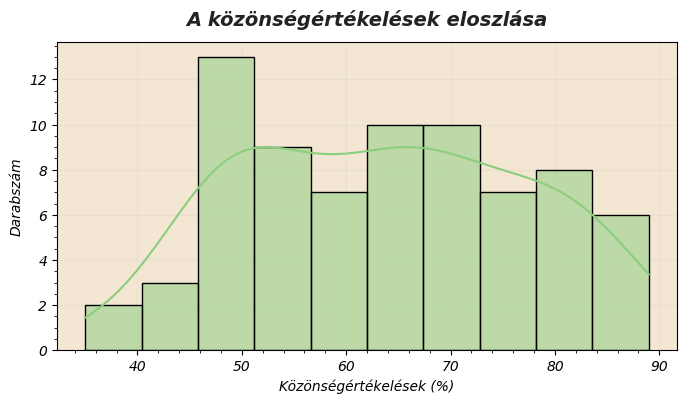

In [143]:
plt.figure(figsize=(8, 4))
sns.histplot(df["Audience score %"], bins=10, kde=True, color="#8ACE7E")
plt.title("A közönségértékelések eloszlása")
plt.xlabel("Közönségértékelések (%)")
plt.ylabel("Darabszám")
plt.show()

**Megfigyelés:**
- Az eloszlás azt mutatja, hogy a legtöbb közönségpontszám a közepes–magas tartományban koncentrálódik.
- Az értékek viszonylag egyenletesen oszlanak meg, kevés extrém alacsony pontszámmal.
- Az eloszlás közel szimmetrikus, markáns ferdeség nem figyelhető meg.

### A Rotten Tomatoes pontszámok eloszlása

**Kérdés:** Hogyan oszlanak meg a kritikusok pontszámai (Rotten Tomatoes %) az adathalmazban?

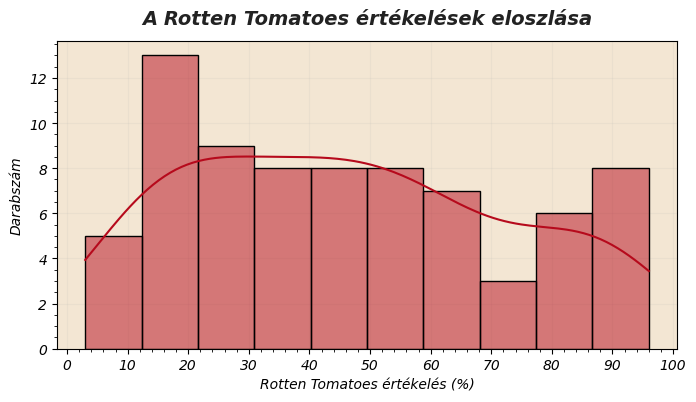

In [144]:
categories = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
plt.figure(figsize=(8, 4))
sns.histplot(df["Rotten Tomatoes %"], bins=10, kde=True, color= "#B60A1C")
plt.xticks(categories)
plt.title("A Rotten Tomatoes értékelések eloszlása")
plt.xlabel("Rotten Tomatoes értékelés (%)")
plt.ylabel("Darabszám")
plt.show()

**Megfigyelés:**
- Az eloszlás szélesebb és szórtabb, mint a közönségpontszámok esetében.
- Jelentősebb számú alacsony érték jelenik meg, miközben néhány kiemelkedően magas pontszám is megfigyelhető.
- Ez a minta a kritikusok véleményei közötti nagyobb mértékű eltérésekre utal.

### Worldwide Gross eloszlása

**Kérdés:** A worldwide gross eloszlása erősen jobbra ferde-e (néhány kiemelkedően nagy bevételű kasszasiker miatt)?

Az eloszlás értelmezhetőségének javítása érdekében logaritmikusan transzformált nézetet is alkalmazok.

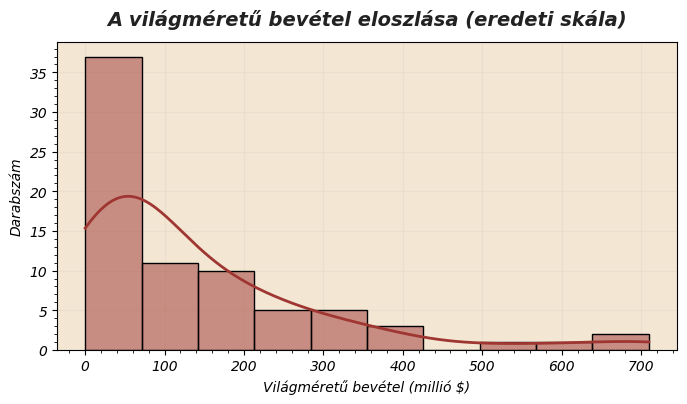

In [145]:
plt.figure(figsize=(8, 4))
sns.histplot(df["Worldwide Gross"], bins=10, kde=True, color= "#9F3632", line_kws={"linewidth": 2})
plt.title("A világméretű bevétel eloszlása (eredeti skála)")
plt.xlabel("Világméretű bevétel (millió $)")
plt.ylabel("Darabszám")
plt.show()

**Megfigyelés:**
- Az eloszlás erősen jobbra ferde, a filmek többsége az alacsonyabb bevételi tartományban koncentrálódik.
- Néhány rendkívül magas bevételű film hosszú jobb oldali „farkat” hoz létre.
- Az eredeti skálán a bevételek közötti különbségek vizuálisan nagyon nagyok, ami jelentős torzulást okoz az ábrán.


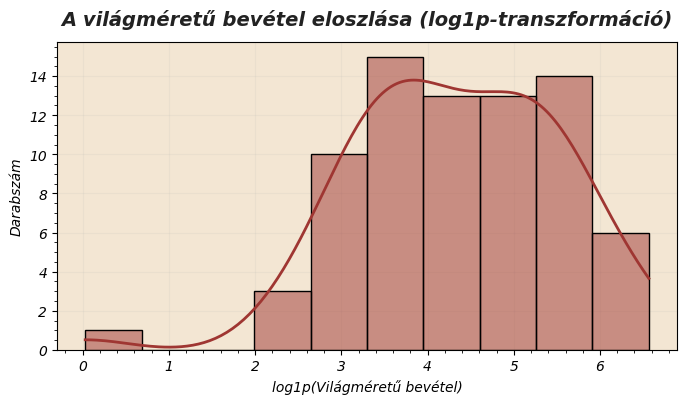

In [146]:
plt.figure(figsize=(8, 4))
sns.histplot(np.log1p(df["Worldwide Gross"]), bins=10, kde=True, color= "#9F3632", line_kws={"linewidth": 2})
plt.title("A világméretű bevétel eloszlása (log1p-transzformáció)")
plt.xlabel("log1p(Világméretű bevétel)")
plt.ylabel("Darabszám")
plt.show()

**Megfigyelés:**
- A log1p transzformáció láthatóan összenyomja a nagyon nagy bevételi értékeket, így az eloszlás könnyebben értelmezhető, mint az eredeti skálán.
- Az értékek többsége nagyjából a 3 és 6 közötti tartományba esik a log1p skálán, azonban az eloszlás alakja továbbra sem teljesen szimmetrikus; a jobb oldal felé fokozatosan lecseng.
- A 0 környékén egy kisebb, elkülönülő csoport figyelhető meg, ami egy rendkívül alacsony bevételű film jelenlétére utal.

<a id="bivariate-analysis"></a>
## 5) Kétváltozós kapcsolatok (bivariáns elemzés)

Ebben a szakaszban a fő változók közötti kapcsolatokat vizsgálom szórásdiagramok segítségével.  
Mivel a **Worldwide Gross** eloszlása erősen jobbra ferde, ahol indokolt, **log1p transzformációt** alkalmazok a mintázatok jobb értelmezhetősége érdekében.


### 5.1 Közönségpontszám vs. Rotten Tomatoes

**Kérdés:** A közönségpontszámok mennyire állnak összhangban a kritikusok (Rotten Tomatoes) értékeléseivel ebben az adathalmazban?

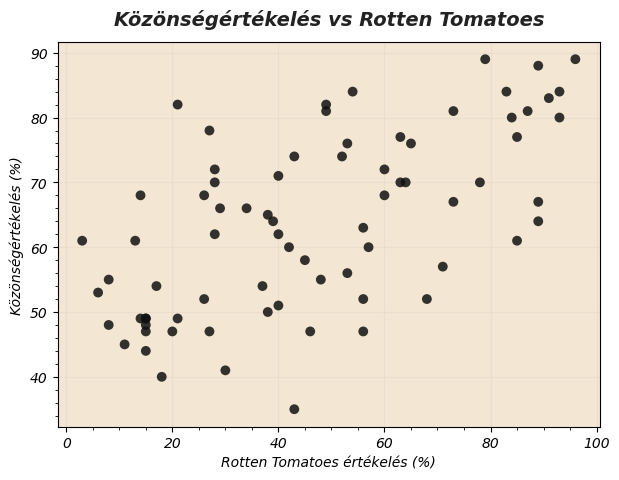

,Rotten Tomatoes %,Audience score %
Rotten Tomatoes %,1.000000,0.616563
Audience score %,0.616563,1.000000


In [147]:
x_col = "Rotten Tomatoes %"
y_col = "Audience score %"

tmp = df[[x_col, y_col]].dropna()

plt.figure(figsize=(7, 5))
plt.scatter(tmp[x_col], tmp[y_col], color= "#111111", s = 50, alpha= 0.85, edgecolors= "none")
plt.title("Közönségértékelés vs Rotten Tomatoes")
plt.xlabel("Rotten Tomatoes értékelés (%)")
plt.ylabel("Közönségértékelés (%)")
plt.show()

#korreláció (rövid numerikus összefoglaló)
tmp[[x_col, y_col]].corr()

**Megfigyelés:**
- A szórásdiagram mérsékelt pozitív kapcsolatot mutat a Rotten Tomatoes kritikuspontszámok és a közönségpontszámok között.
- A kritikusok pontszámának növekedésével a közönségpontszámok is jellemzően emelkednek, ugyanakkor számottevő szórás figyelhető meg, ami arra utal, hogy az összefüggés nem tökéletes.
- Több pont eltér az általános trendtől, ami azt jelzi, hogy egyes filmeket a kritikusok és a közönség eltérően ítél meg, még hasonló pontszámok mellett is.
- A korrelációs együttható (≈ 0,62) alátámasztja a vizuális benyomást: a kapcsolat mérsékelt, de nem erős lineáris összefüggés.

### 5.2 Worldwide Gross vs. közönségpontszám

**Kérdés:** A magasabb közönségpontszámok együtt járnak-e magasabb világméretű bevétellel?

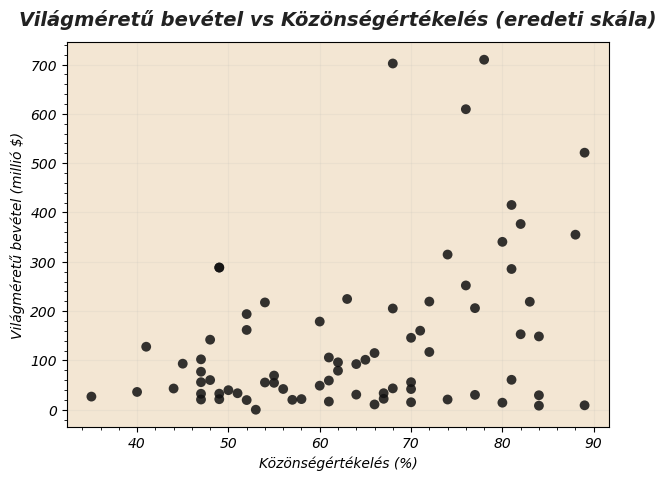

In [148]:
x_col = "Audience score %"
y_col = "Worldwide Gross"

tmp = df[[x_col, y_col]].dropna()

plt.figure(figsize=(7, 5))
plt.scatter(tmp[x_col], tmp[y_col], color= "#111111", s = 50, alpha= 0.85, edgecolors= "none")
plt.title("Világméretű bevétel vs Közönségértékelés (eredeti skála)")
plt.xlabel("Közönségértékelés (%)")
plt.ylabel("Világméretű bevétel (millió $)")
plt.show()

**Megfigyelés (eredeti skála):**
- Az eredeti skálán a közönségpontszám és a világméretű bevétel közötti kapcsolat nem mutat egyértelmű lineáris összefüggést.
- A filmek többsége alacsonyabb bevételi tartományban koncentrálódik a közönségpontszámok széles skálája mellett, ami arra utal, hogy a magasabb közönségértékelés nem jár automatikusan magas bevétellel.
- Néhány rendkívül magas bevételű kiugró érték dominálja a függőleges skálát, ami megnehezíti a finomabb mintázatok felismerését a filmek többsége esetében.
- Összességében az ábra arra utal, hogy a közönségpontszámon túlmutató tényezők (pl. forgalmazás, marketing, franchise-hatások) jelentős szerepet játszanak, így a közönségpontszám önmagában korlátozott előrejelző erejű ezen a skálán.

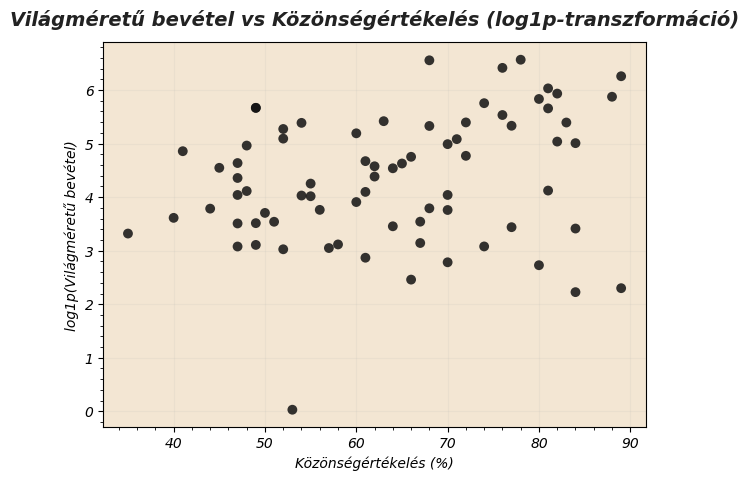

,Audience score %,log1p_gross
Audience score %,1.000000,0.260821
log1p_gross,0.260821,1.000000


In [149]:
# --- 5.2 Gross vs Audience (log1p skála) ---

tmp = df[[x_col, y_col]].dropna().copy()
tmp["log1p_gross"] = np.log1p(tmp[y_col])

plt.figure(figsize=(7, 5))
plt.scatter(tmp[x_col], tmp["log1p_gross"], color= "#111111", s = 50, alpha= 0.85, edgecolors= "none")
plt.title("Világméretű bevétel vs Közönségértékelés (log1p-transzformáció)")
plt.xlabel("Közönségértékelés (%)")
plt.ylabel("log1p(Világméretű bevétel)")
plt.show()

# korreláció log skálán
tmp[[x_col, "log1p_gross"]].corr()

**Megfigyelés (log1p skála):**
- A log1p transzformáció csökkenti a szélsőséges bevételi értékek hatását, így az eloszlás összességében könnyebben értelmezhetővé válik.
- Az ábra legfeljebb gyenge pozitív kapcsolatot sugall a közönségpontszám és a világméretű bevétel között.
- A közönségpontszámok középső tartományában is jelentős szóródás figyelhető meg, ami arra utal, hogy a bevételi eredményeket további tényezők is erősen befolyásolják.
- A logaritmikusan transzformált skálán az adatok szerkezete tisztábban kirajzolódik, azonban továbbra sem azonosítható erős lineáris összefüggés.

### 5.3 Worldwide Gross vs. Rotten Tomatoes

**Kérdés:** A magasabb kritikuspontszámok (Rotten Tomatoes) együtt járnak-e magasabb világméretű bevétellel?

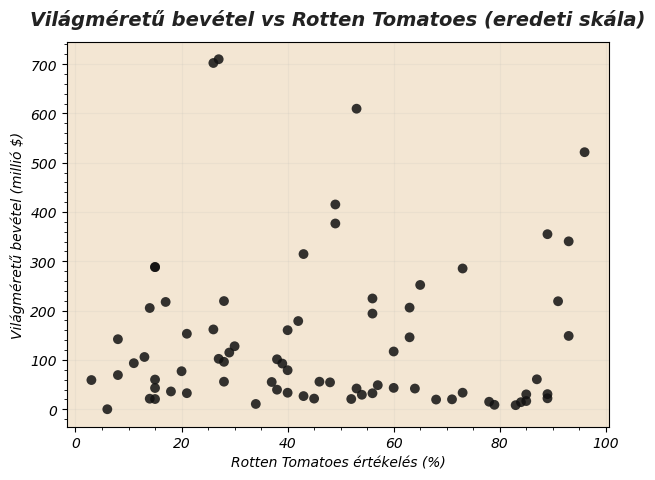

In [150]:
# --- 5.3 Bevétel vs. Rotten Tomatoes (eredeti skála) ---

x_col = "Rotten Tomatoes %"
y_col = "Worldwide Gross"

tmp = df[[x_col, y_col]].dropna()

plt.figure(figsize=(7, 5))
plt.scatter(tmp[x_col], tmp[y_col], color= "#111111", s = 50, alpha= 0.85, edgecolors= "none")
plt.title("Világméretű bevétel vs Rotten Tomatoes (eredeti skála)")
plt.xlabel("Rotten Tomatoes értékelés (%)")
plt.ylabel("Világméretű bevétel (millió $)")
plt.show()

**Megfigyelés (eredeti skála):**
- Az ábra nem mutat egyértelmű vagy erős kapcsolatot a Rotten Tomatoes pontszámok és a világméretű bevétel között.
- Magas és alacsony bevételi eredmények is megjelennek szinte a kritikuspontszámok teljes tartományában.
- Néhány rendkívül magas bevételű film már közepes vagy alacsonyabb Rotten Tomatoes értékelés mellett is előfordul, ami vizuálisan torzítja az összképet.
- Ez arra utal, hogy a kritikuspontszám önmagában valószínűleg nem meghatározó tényező a világméretű jegybevétel alakulásában.

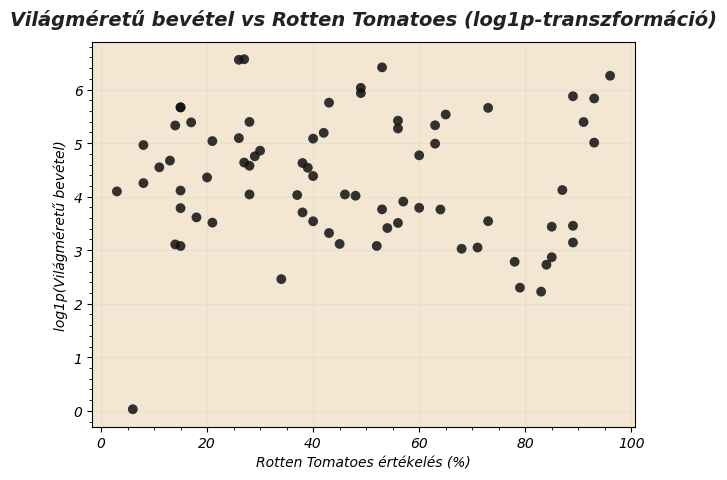

,Rotten Tomatoes %,log1p_gross
Rotten Tomatoes %,1.000000,-0.053129
log1p_gross,-0.053129,1.000000


In [151]:
# --- 5.3 Gross vs Rotten Tomatoes (log1p skála) ---

tmp = df[[x_col, y_col]].dropna().copy()
tmp["log1p_gross"] = np.log1p(tmp[y_col])

plt.figure(figsize=(7, 5))
plt.scatter(tmp[x_col], tmp["log1p_gross"], color= "#111111", s = 50, alpha= 0.85, edgecolors= "none")
plt.title("Világméretű bevétel vs Rotten Tomatoes (log1p-transzformáció)")
plt.xlabel("Rotten Tomatoes értékelés (%)")
plt.ylabel("log1p(Világméretű bevétel)")
plt.show()

# korreláció log skálán
tmp[[x_col, "log1p_gross"]].corr()

**Megfigyelés (log1p skála):**
- A log1p transzformáció csökkenti a szélsőséges bevételi értékek vizuális dominanciáját, így az eloszlás összességében könnyebben értelmezhetővé válik.
- Még a transzformált skálán sem rajzolódik ki egyértelmű kapcsolat a Rotten Tomatoes pontszámok és a világméretű bevétel között.
- A pontok továbbra is széles körben szóródnak, hasonló bevételi szintek jelennek meg a kritikuspontszámok széles tartományában.
- A közel zérus korreláció arra utal, hogy a kritikuspontszámoknak kevés vagy semmilyen következetes kapcsolatuk nincs a globális jegybevétel alakulásával.

### 5.4 Profitability vs. Worldwide Gross

**Kérdés:** Az adathalmazban a magasabb bevételű filmek egyben jövedelmezőbbek is?


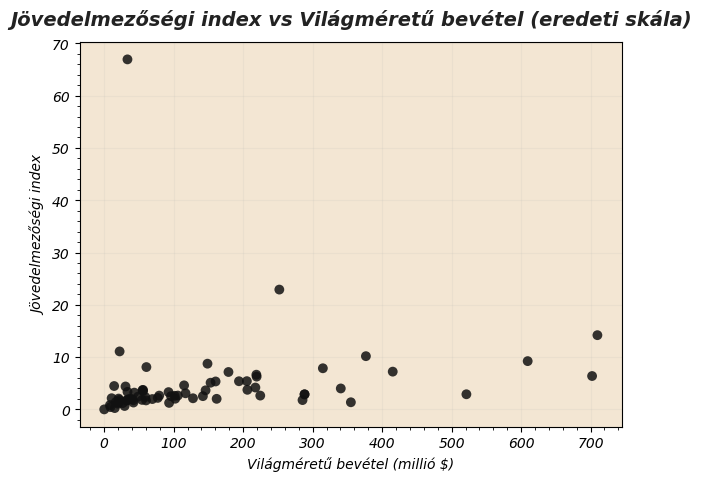

In [152]:
# --- 5.4 Profitability vs Gross (eredeti skála) ---

x_col = "Worldwide Gross"
y_col = "Profitability"

tmp = df[[x_col, y_col]].dropna()

plt.figure(figsize=(7, 5))
plt.scatter(tmp[x_col], tmp[y_col], color= "#111111", s = 50, alpha= 0.85, edgecolors= "none")
plt.title("Jövedelmezőségi index vs Világméretű bevétel (eredeti skála)")
plt.xlabel("Világméretű bevétel (millió $)")
plt.ylabel("Jövedelmezőségi index")
plt.show()

**Megfigyelés (eredeti skála):**
- Az ábra nem mutat egyértelmű lineáris kapcsolatot a világméretű bevétel és a jövedelmezőség között.
- A magasabb Worldwide Gross nem jár következetesen magasabb jövedelmezőségi értékekkel.
- Néhány alacsonyabb bevételű film relatíve magas jövedelmezőséget mutat bizonyos, magas bevételű címekhez képest.
- Ez arra utal, hogy a bevétel önmagában nem elegendő a filmek közötti jövedelmezőségi különbségek magyarázatához.

Ezek a megfigyelések vizuális mintázatokon alapulnak, ezért óvatosan értelmezendők, mivel a jövedelmezőséget a költségstruktúrák is befolyásolják, amelyek ebben az adathalmazban nem figyelhetők meg közvetlenül.

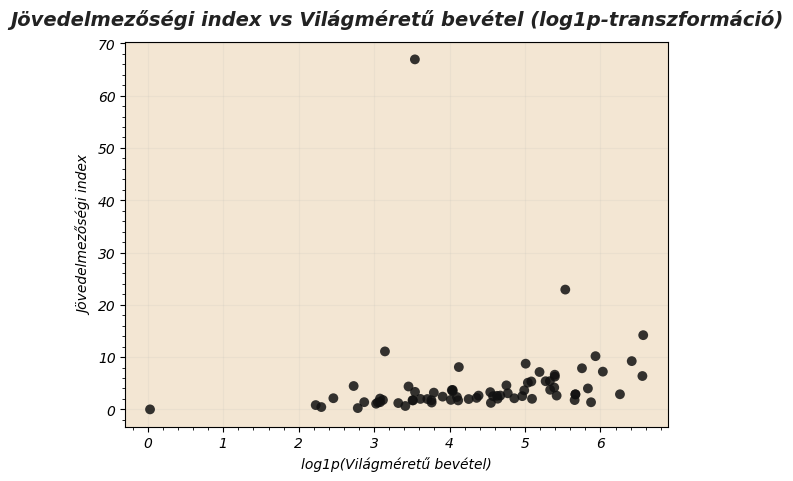

,log1p_gross,Profitability
log1p_gross,1.000000,0.133475
Profitability,0.133475,1.000000


In [153]:
# --- 5.4 Profitability vs Gross (log1p gross) ---

tmp = df[[x_col, y_col]].dropna().copy()
tmp["log1p_gross"] = np.log1p(tmp[x_col])

plt.figure(figsize=(7, 5))
plt.scatter(tmp["log1p_gross"], tmp[y_col], color= "#111111", s = 50, alpha= 0.85, edgecolors= "none")
plt.title("Jövedelmezőségi index vs Világméretű bevétel (log1p-transzformáció)")
plt.xlabel("log1p(Világméretű bevétel)")
plt.ylabel("Jövedelmezőségi index")
plt.show()

# korreláció log skálán
tmp[["log1p_gross", y_col]].corr()


**Megfigyelés (log1p skála):**
- Az ábra nem mutat erős kapcsolatot a világméretű bevétel és a jövedelmezőség között.
- A log1p transzformáció alkalmazása csökkenti a szélsőséges bevételi értékek hatását, ugyanakkor az adatpontok továbbra is széles körben szóródnak.
- A magasabb bevételű filmek nem mutatnak következetesen magasabb jövedelmezőséget.
- Ez arra utal, hogy a bevétel önmagában nem kulcsmeghatározó tényező a jövedelmezőség szempontjából, és további tényezők (például gyártási vagy marketingköltségek) is befolyásolhatják az eredményeket.
- A gyenge korreláció alátámasztja, hogy ez a kapcsolat inkább gyenge jellegű, semmint előrejelző erejű.

<a id="6-kozonsegkozpontu-vizualizaciok"></a>
## 6) Közönségközpontú vizualizációk

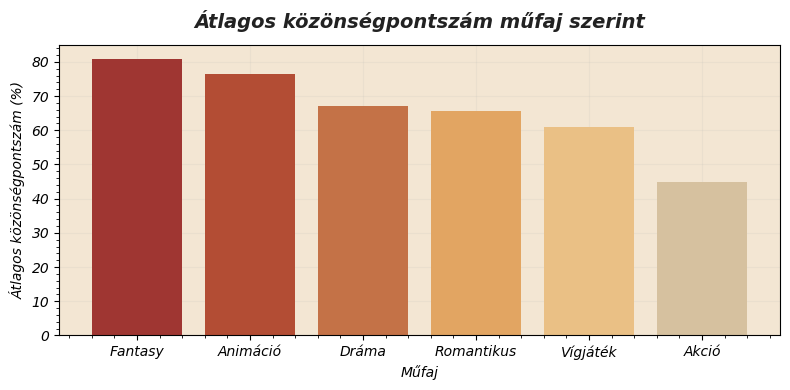

In [154]:
genre_avg = (
    df.groupby("Genre")["Audience score %"]
      .mean()
      .sort_values(ascending=False)
)

hu_labels = {
    "Fantasy": "Fantasy",
    "Animation": "Animáció",
    "Drama": "Dráma",
    "Romance": "Romantikus",
    "Comedy": "Vígjáték",
    "Action": "Akció"
}

# itt történik a magyarosítás
genre_avg.index = genre_avg.index.map(hu_labels)

plt.figure(figsize=(8, 4))
colors = ["#9F3632", "#B34D34", "#C47247", "#E2A562", "#EAC085", "#D6C19F"]
plt.bar(genre_avg.index, genre_avg.values, color=colors)

plt.title("Átlagos közönségpontszám műfaj szerint")
plt.xlabel("Műfaj")
plt.ylabel("Átlagos közönségpontszám (%)")

plt.tight_layout()
plt.show()


**Magyarázat:**  
Ez az ábra azt mutatja be, hogy a közönség átlagosan hogyan értékelte a különböző műfajú filmeket.  
Minden oszlop egy-egy műfajt jelöl, az oszlop magassága pedig az adott műfajba tartozó filmek átlagos közönségpontszámát (%) mutatja.  
A műfajok csökkenő sorrendben vannak rendezve, így könnyen összehasonlítható, hogy mely filmtípusokat kedvelte leginkább a közönség.  
A vizualizáció célja, hogy gyors és intuitív áttekintést adjon a közönségpreferenciákról.


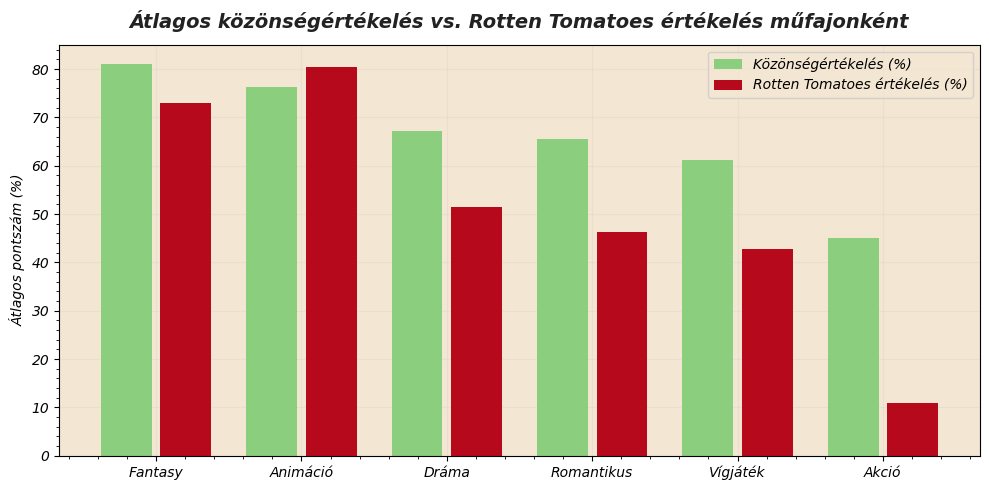

In [155]:
genre_means = (
    df.groupby("Genre")[["Audience score %", "Rotten Tomatoes %"]]
      .mean()
      .dropna()
      .sort_values("Audience score %", ascending=False)
)

hu_labels = {
    "Fantasy": "Fantasy",
    "Animation": "Animáció",
    "Drama": "Dráma",
    "Romance": "Romantikus",
    "Comedy": "Vígjáték",
    "Action": "Akció"
}

# magyarítás itt
genre_means.index = genre_means.index.map(hu_labels)

x = np.arange(len(genre_means.index))
w = 0.35
gap = 0.06

plt.figure(figsize=(10, 5))
plt.bar(
    x - (w/2 + gap/2),
    genre_means["Audience score %"],
    width=w,
    label="Közönségértékelés (%)",
    color="#8ACE7E"
)
plt.bar(
    x + (w/2 + gap/2),
    genre_means["Rotten Tomatoes %"],
    width=w,
    label="Rotten Tomatoes értékelés (%)",
    color="#B60A1C"
)

plt.title("Átlagos közönségértékelés vs. Rotten Tomatoes értékelés műfajonként")
plt.xticks(x, genre_means.index)
plt.ylabel("Átlagos pontszám (%)")
plt.legend()
plt.tight_layout()
plt.show()

**Magyarázat:**  
Ez az ábra a különböző film műfajok esetében hasonlítja össze a közönség átlagos pontszámait és a Rotten Tomatoes kritikusértékeléseit.  
Minden műfajnál két egymás melletti oszlop látható: az egyik az átlagos közönségpontszámot, a másik az átlagos Rotten Tomatoes pontszámot jelöli.  
A műfajok a közönségpontszám alapján csökkenő sorrendben vannak rendezve, így könnyen azonosítható, hogy hol esik egybe, illetve hol tér el a közönség és a kritikusok véleménye.  
A vizualizáció célja, hogy világos és intuitív módon rávilágítson a közönségpreferenciák és a kritikai értékelések közötti különbségekre.

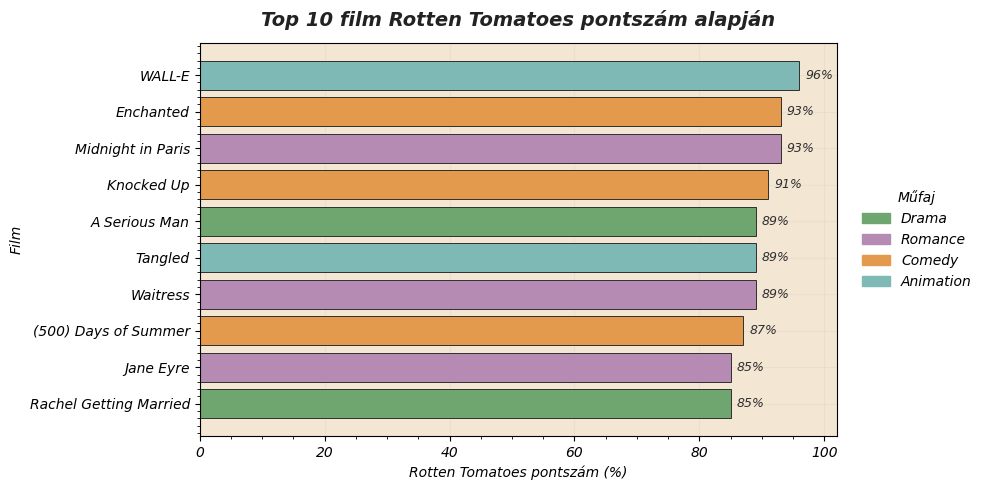

In [156]:
genre_colors = {
    "Action":    "#5B7DB1",
    "Comedy":    "#E39A4C",
    "Drama":     "#6FA56F",
    "Romance":   "#B58BB3",
    "Animation": "#7FB9B6",
    "Fantasy":   "#A07C6A"
}

# A Rotten Tomatoes pontszám alapján a 10 legmagasabbra értékelt film kiválasztása
top10_rt = (
    df[["Film", "Genre", "Rotten Tomatoes %"]]
    .dropna()
    .nlargest(10, "Rotten Tomatoes %")
    .sort_values("Rotten Tomatoes %")
)

colors = top10_rt["Genre"].map(genre_colors)

plt.figure(figsize=(10, 5))
plt.barh(
    top10_rt["Film"],
    top10_rt["Rotten Tomatoes %"],
    color=colors,
    edgecolor="#2F2F2F",
    linewidth=0.7
)

# Értékek kiírása az oszlopokra
for i, v in enumerate(top10_rt["Rotten Tomatoes %"]):
    plt.text(v + 1, i, f"{v:.0f}%", va="center", fontsize=9, color="#2F2F2F")
plt.xlim(0, 102)
plt.title("Top 10 film Rotten Tomatoes pontszám alapján")
plt.xlabel("Rotten Tomatoes pontszám (%)")
plt.ylabel("Film")

# Az oszlopok színei a filmek műfajait jelölik
genres_in_plot = top10_rt["Genre"].dropna().unique()
handles = [mpatches.Patch(color=genre_colors[g], label=g) for g in genres_in_plot]

plt.legend(
    handles=handles,
    title="Műfaj",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False
)

plt.tight_layout()
plt.show()

**Magyarázat:**  
Ez az ábra a Rotten Tomatoes kritikusértékelései alapján a 10 legmagasabb pontszámot elérő filmet mutatja be.  
Minden oszlop egy filmet jelöl, az oszlop hossza pedig a Rotten Tomatoes pontszámát (%) tükrözi.  
Az oszlopok műfaj szerint vannak színezve, ami lehetővé teszi, hogy gyorsan áttekinthető legyen, mely műfajok képviseltetik magukat a legjobbra értékelt filmek között.  
A vizualizáció célja a kiemelkedően teljesítő filmek bemutatása, miközben a műfaji megoszlást is intuitív, könnyen értelmezhető módon szemlélteti.

<a id="7-kovetkeztetesek"></a>
## 7) Következtetések

Az elemzés azt mutatja, hogy a közönségpontszámok és a kritikusok értékelései mérsékelten korrelálnak egymással, ami részleges összhangra utal az általános közönségfogadtatás és a szakmai vélemények között, ugyanakkor teret hagy jelentősebb eltéréseknek egyes filmek esetében.

Sem a közönség-, sem a kritikuspontszámok nem mutatnak erős vagy következetes kapcsolatot a világméretű jegybevétellel. Számos magasra értékelt film csupán mérsékelt kereskedelmi sikert ér el, miközben sok kiemelkedően nagy bevételű film átlagos vagy akár alacsony értékeléseket kap. Ez arra utal, hogy a box office teljesítményt további tényezők is jelentősen befolyásolják, például a marketing intenzitása, a franchise-jelleg, a bemutatás időzítése és a forgalmazás mértéke.

A jövedelmezőség és a világméretű bevétel között csak gyenge kapcsolat figyelhető meg, még a logaritmikusan transzformált bevétel alkalmazása után is. Számos alacsonyabb bevételű film viszonylag magas jövedelmezőséget ér el, míg egyes nagy bevételű produkciók csupán szerény megtérülést mutatnak. Ez rávilágít a gyártási költségek és a költséghatékonyság fontosságára, amelyek az elérhető adatokban nem figyelhetők meg közvetlenül.

A műfajszintű elemzés szisztematikus különbségeket tár fel a közönség és a kritikusok értékelései között. Szinte minden műfajban a közönség átlagos pontszámai magasabbak, mint a Rotten Tomatoes kritikuspontszámok, ami arra utal, hogy a közönség általában kedvezőbben ítéli meg a filmeket, mint a kritikusok. A különbség mértéke műfajonként eltér, ami a közönség elvárásai és a kritikai szempontok közötti eltéréseket tükrözi. Az animációs filmek kiemelkednek, mint figyelemre méltó kivétel: ebben a műfajban a kritikuspontszámok enyhén meghaladják a közönségértékeléseket, ami erősebb kritikai konszenzusra utal a közönségfogadtatáshoz képest.

Összességében az eredmények azt mutatják, hogy az értékelések önmagukban korlátozott előrejelzői a kereskedelmi vagy pénzügyi sikernek. Egy film teljesítménye összetett jelenség, amelyet a közönségvonzó erő, a kritikai fogadtatás, a műfaji sajátosságok és a számszerű értékeléseken túlmutató üzleti tényezők együttesen alakítanak.